# DECOMON tutorial #3 
## Local Robustness to Adversarial Attacks for classification tasks

## Introduction

After training a model, we want to make sure that the model will give the same output for any images "close" to the initial one, showing some robustness to perturbation. 

In this notebook, we start from a classifier built on MNIST dataset that given a hand-written digit as input will predict the digit. This will be the first part of the notebook.

<img src="./data/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png" alt="examples of hand-written digit" width="600"/>

In the second part of the notebook, we will investigate the robustness of this model to unstructured modification of the input space: adversarial attacks. For this kind of attacks, **we vary the magnitude of the perturbation of the initial image** and want to assess that despite this noise, the classifier's prediction remain unchanged.

<img src="./data/illustration_adv_attacks.jpeg" alt="examples of hand-written digit" width="600"/>

What we will show is the use of decomon module to assess the robustness of the prediction towards noise.

## The notebook

### imports

In [1]:
import os

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow.keras as keras

%matplotlib inline
import sys
import time

import ipywidgets as widgets
import numpy as np
from ipywidgets import interact
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

sys.path.append("..")
import os
import os.path
import pickle as pkl
import time
from contextlib import closing

In [2]:
import tensorflow as tf

In [4]:
from decomon.wrapper import refine_boxes

In [5]:
x_min = np.ones((3, 4, 5))
x_max = 2 * x_min

In [6]:
refine_boxes(x_min, x_max, 10)

> /Users/ducoffe/Documents/Code/open_sourcing/Airbus/decomon/decomon/wrapper.py(1065)split()
   1063         split_value = np.array([mid_x[i, index_k, j[i]] for i in index_0])
   1064         import pdb; pdb.set_trace()
-> 1065         for i in index_0:
   1066             X_min_[i, 1, index_k, j[i]] = split_value[i]
   1067             X_max_[i, 0, index_k, j[i]] = split_value[i]

ipdb> p split_value.shape
(3, 1)
ipdb> c
> /Users/ducoffe/Documents/Code/open_sourcing/Airbus/decomon/decomon/wrapper.py(1065)split()
   1063         split_value = np.array([mid_x[i, index_k, j[i]] for i in index_0])
   1064         import pdb; pdb.set_trace()
-> 1065         for i in index_0:
   1066             X_min_[i, 1, index_k, j[i]] = split_value[i]
   1067             X_max_[i, 0, index_k, j[i]] = split_value[i]

ipdb> p split_value.shape
(3, 2)
ipdb> c
> /Users/ducoffe/Documents/Code/open_sourcing/Airbus/decomon/decomon/wrapper.py(1065)split()
   1063         split_value = np.array([mid_x[i, index_

(array([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 

### load images

We load MNIST data from keras datasets. 


In [3]:
ara
img_rows, img_cols = 28, 28
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train_)
y_test = keras.utils.to_categorical(y_test_)



### learn the model (classifier for MNIST images)

For the model, we use a small fully connected network. It is made of 6 layers with 100 units each and ReLU activation functions. **Decomon** is compatible with a large set of Keras layers, so do not hesitate to modify the architecture.


In [4]:
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=784))
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [5]:
model.compile("adam", "categorical_crossentropy", metrics="acc")

model.fit(x_train, y_train, batch_size=32, shuffle=True, validation_split=0.2, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4626 - acc: 0.8668 - val_loss: 0.1406 - val_acc: 0.9591
Epoch 2/5
1500/1500 [==============================] - 1s 916us/step - loss: 0.1183 - acc: 0.9643 - val_loss: 0.1176 - val_acc: 0.9661
Epoch 3/5
1500/1500 [==============================] - 1s 909us/step - loss: 0.0794 - acc: 0.9741 - val_loss: 0.1068 - val_acc: 0.9688
Epoch 4/5
1500/1500 [==============================] - 1s 896us/step - loss: 0.0586 - acc: 0.9810 - val_loss: 0.1010 - val_acc: 0.9709
Epoch 5/5
1500/1500 [==============================] - 1s 912us/step - loss: 0.0426 - acc: 0.9862 - val_loss: 0.1226 - val_acc: 0.9669


In [6]:
model.evaluate(x_test, y_test, batch_size=32)

313/313 [==============================] - 0s 920us/step - loss: 0.1193 - acc: 0.9666


[0.11925949901342392, 0.9666000008583069]

After training, we see that the assessment of performance of the model on data that was not seen during training shows pretty good results: around 0.97 (maximum value is 1). It means that out of 100 images, the model was able to guess the correct digit for 97 images. But how can we guarantee that we will get this performance for images different from the ones in the test dataset? 

- If we perturbate a "little" an image that was well predicted, will the model stay correct? 
- Up to which perturbation?  
- Can we guarantee that the model will output the same digit for a given perturbation? 

This is where decomon comes in. 

<img src="./data/decomon.jpg" alt="Decomon!" width="400"/>



### Applying Decomon for Local Robustness to misclassification

In this section, we detail how to prove local robustness to misclassification. Misclassification can be studied with the global optimisation of a function f:

$$ f(x; \Omega) = \max_{z\in \Omega} \text{NN}_{j\not= i}(z) - \text{NN}_i(z)\;\; \text{s.t}\;\; i = argmax\;\text{NN}(x)$$

If the maximum of f is **negative**, this means that whathever the input sample from the domain, the value outputs by the neural network NN for class i will always be greater than the value output for another class. Hence, there will be no misclassification possible. This is **adversarial robustness**.

<img src="./data/tuto_3_formal_robustness.png" alt="Decomon!" width="400"/>

In that order, we will use the [decomon](https://gheprivate.intra.corp/CRT-DataScience/decomon/tree/master/decomon) library. Decomon combines several optimization trick, including linear relaxation
to get state-of-the-art outer approximation.

To use **decomon** for **adversarial robustness** we first need the following imports:
+ *from decomon.models import convert*: to convert our current Keras model into another neural network nn_model. nn_model will output the same prediction that our model and adds extra information that will be used to derive our formal bounds. For a sake of clarity, how to get such bounds is hidden to the user

+ *from decomon import get_adv_box*: a genereric method to get an upper bound of the funtion f described previously. If the returned value is negative, then we formally assess the robustness to misclassification.

+ *from decomon import check_adv_box*: a generic method that computes the maximum of a lower bound of f. Eventually if this value is positive, it demonstrates that the function f takes positive value. It results that a positive value formally proves the existence of misclassification.


In [7]:
from decomon import check_adv_box, get_adv_box
from decomon.models import convert

For computational efficiency, we convert the model into its decomon version once and for all.
Note that the decomon method will work on the non-converted model. To obtain more refined guarantees, we activate an option denoted **forward**. You can speed up the method by removing this option in the convert method.

In [8]:
decomon_model = convert(model)

In [9]:
from decomon import build_formal_adv_model

In [10]:
adv_model = build_formal_adv_model(decomon_model)

In [11]:
x_ = x_train[:1]
eps = 1e-2
z = np.concatenate([x_[:, None] - eps, x_[:, None] + eps], 1)

In [12]:
get_adv_box(decomon_model, x_, x_, source_labels=y_train[0].argmax())

array([-7.406623], dtype=float32)

In [13]:
adv_model.predict([x_, z, y_train[:1]])

array([-1.961668], dtype=float32)

In [14]:
# compute gradient
import tensorflow as tf

In [27]:
x_tensor = tf.convert_to_tensor(x_, dtype=tf.float32)

In [28]:
from tensorflow.keras.layers import Concatenate

In [29]:
with tf.GradientTape() as t:
    t.watch(x_tensor)
    z_tensor = Concatenate(1)([x_tensor[:, None] - eps, x_tensor[:, None] + eps])
    output = adv_model([x_, z_tensor, y_train[:1]])

In [30]:
result = output
gradients = t.gradient(output, x_tensor)
mask = gradients.numpy()
# scale between 0 and 1.
mask = mask - mask.min()

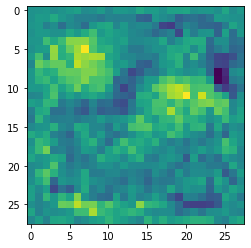

In [31]:
plt.imshow(gradients.numpy().reshape((28, 28)))

In [21]:
img_mask = np.zeros((784,))
img_mask[np.argsort(mask[0])[::-1][:100]] = 1

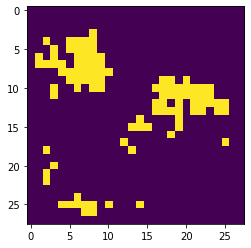

In [22]:
plt.imshow(img_mask.reshape((28, 28)))

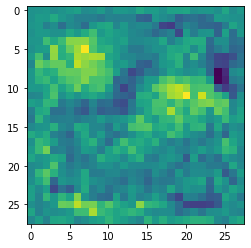

In [23]:
plt.imshow(mask.reshape((28, 28)))

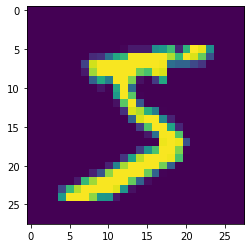

In [24]:
plt.imshow(x_.reshape((28, 28)))

We offer an interactive visualisation of the basic adversarial robustness method from decomon **get_adv_upper**. We randomly choose 10 test images use **get_adv_upper** to assess their robustness to misclassification pixel perturbations. The magnitude of the noise on each pixel is independent and bounded by the value of the variable epsilon. The user can reset the examples and vary the noise amplitude.

Note one of the main advantage of decomon: **we can assess robustness on batches of data!**

Circled in <span style="color:green">green</span> are examples that are formally assessed to be robust, <span style="color:orange">orange</span> examples that could be robust and  <span style="color:red">red</span> examples that are formally non robust

In [9]:
def frame(epsilon, reset=0, filename="./data/.hidden_index.pkl"):
    n_cols = 5
    n_rows = 2
    n_samples = n_cols * n_rows
    if reset:
        index = np.random.permutation(len(x_test))[:n_samples]

        with closing(open(filename, "wb")) as f:
            pkl.dump(index, f)
        # save data
    else:
        # check that file exists

        if os.path.isfile(filename):
            with closing(open(filename, "rb")) as f:
                index = pkl.load(f)
        else:
            index = np.arange(n_samples)
            with closing(open(filename, "wb")) as f:
                pkl.dump(index, f)
    # x = np.concatenate([x_test[0:1]]*10, 0)
    x = x_test[index]

    x_min = np.maximum(x - epsilon, 0)
    x_max = np.minimum(x + epsilon, 1)

    n_cols = 5
    n_rows = 2
    fig, axs = plt.subplots(n_rows, n_cols)

    fig.set_figheight(n_rows * fig.get_figheight())
    fig.set_figwidth(n_cols * fig.get_figwidth())
    plt.subplots_adjust(hspace=0.2)  # increase vertical separation
    axs_seq = axs.ravel()

    source_label = np.argmax(model.predict(x), 1)
    start_time = time.process_time()
    upper = get_adv_box(decomon_model, x_min, x_max, source_labels=source_label)
    lower = check_adv_box(decomon_model, x_min, x_max, source_labels=source_label)
    end_time = time.process_time()
    count = 0
    time.sleep(1)
    r_time = "{:.2f}".format(end_time - start_time)
    fig.suptitle(
        "Formal Robustness to Adversarial Examples with eps={} running in {} seconds".format(epsilon, r_time),
        fontsize=16,
    )
    for i in range(n_cols):
        for j in range(n_rows):

            ax = axs[j, i]
            ax.imshow(x[count].reshape((28, 28)), cmap="Greys")
            robust = "ROBUST"
            if lower[count] >= 0:
                color = "red"
                robust = "NON ROBUST"
            elif upper[count] < 0:
                color = "green"
            else:
                color = "orange"
                robust = "MAYBE ROBUST"

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            # Create a Rectangle patch
            rect = patches.Rectangle((0, 0), 27, 27, linewidth=3, edgecolor=color, facecolor="none")
            ax.add_patch(rect)
            ax.set_title(robust)
            count += 1


interact(
    frame,
    epsilon=widgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=5.0 / 255.0,
        step=0.0001,
        continuous_update=False,
        readout_format=".4f",
    ),
    reset=widgets.IntSlider(value=0.0, min=0, max=1, step=1, continuous_update=False),
    fast=widgets.IntSlider(value=1.0, min=0, max=1, step=1, continuous_update=False),
)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='epsilon', max=0.01960784313…

<function __main__.frame(epsilon, reset=0, filename='./data/.hidden_index.pkl')>

As explained previously, the method **get_adv_upper** output a constant upper bound that is valid on the whole domain.
Sometimes, this bound can be too lose and needs to be refined by splitting the input domain into sub domains.
Several heuristics are possible and you are free to develop your own or take an existing one of the shelf.